In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import datetime
import scipy.stats as stats

/mnt/ShareDrive/Development/UzK/COINs-CNN-FLOW/Uvenv/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Function Definitions

In [2]:
def clean_sub_count(count):
    count = str(count).replace('\xa0',' ')
    if 'Mio.' in count:
        count = int(float(count.split(' ')[0].replace(',','.')) * 1000000)
    elif count == 'nan':
        count = 1
    else:
        count = int(count.split(' ')[0].replace('.',''))
    return count

# Data Preparation

## Data Imports

### Flow Data

In [3]:
flow_predictions = pd.read_csv('../results/yt_analysis/results.csv')

# Type conversions
flow_predictions['VID'] = flow_predictions.FILE.apply(lambda x: int(x.split('_')[0].split('/')[-1]))
flow_predictions['FRAME'] = flow_predictions.FILE.apply(lambda x: int(x.split('_')[-4]))
flow_predictions['FLOW_C'] = flow_predictions.FILE.apply(lambda x: int(x.split('_')[-2]))
flow_predictions.drop(columns=['FILE'], inplace=True)

# Flow prediction as class
flow_predictions.loc[flow_predictions['PROB'] >= 0.5, 'FLOW_P_C'] = int(1)
flow_predictions.loc[flow_predictions['PROB'] < 0.5, 'FLOW_P_C'] = int(0)

flow_predictions.rename(columns={'PROB':'FlowProbability'}, inplace=True)
flow_predictions.head(5)

,FlowProbability,VID,FRAME,FLOW_C,FLOW_P_C
0,0.652541,11,7258,1,1.0
1,0.518073,13,574,0,1.0
2,0.592700,12,6192,0,1.0
3,0.474445,42,7136,0,0.0
4,0.345597,19,1075,0,0.0


### Video Stats

In [4]:
video_stats = pd.read_csv('../results/yt_analysis/video_stats_enhanced.csv', sep=',').drop(columns=['url','Frames_CV','commentCount'])
video_stats['Zeit'] = video_stats['Zeit'].apply(lambda x: float(x.replace(',','.')))
video_stats['date_published'] = video_stats['date_published'].apply(lambda x: x.split(' ')[-1])
video_stats['days_published'] = (pd.to_datetime(video_stats['date_published']) - pd.to_datetime(datetime.date.today())).apply(lambda x: x.days * -1)

video_stats['channel_subscribers'] = video_stats['channel_subscribers'].apply(clean_sub_count)

video_stats['LikeViewRatio'] = video_stats['likeCount'] / video_stats['viewCount']
#video_stats['dislikeRatio'] = video_stats['dislikeCount'] / video_stats['viewCount']
#video_stats['LikeDislikeRatio'] = video_stats['dislikeCount'] / video_stats['likeCount']

video_stats['LogSubscribers'] = video_stats['channel_subscribers'].apply(np.log)
video_stats['LogDaysPublic'] = video_stats['days_published'].apply(np.log)

#video_stats['LogLikeCount'] = video_stats['likeCount'].apply(np.log1p)
#video_stats['LogDisLikeCount'] = video_stats['dislikeCount'].apply(np.log1p)
video_stats['LogViewCount'] = video_stats['viewCount'].apply(np.log)

video_stats.rename(columns={'Frames':'YT_FRAMES', 'FRAMES_CV':'CVAT_FRAMES', 'Zeit':'VID_LEN'}, inplace=True)
video_stats.head(5)

,id,viewCount,likeCount,dislikeCount,YT_FRAMES,VID_LEN,date_published,duration,channel_subscribers,days_published,LikeViewRatio,LogSubscribers,LogDaysPublic,LogViewCount
0,1,48134273.0,268268.0,6901.0,12150.0,6.75,21.07.2009,0:06,1470000,4125,0.005573,14.200773,8.324821,17.689505
1,2,6425717.0,28765.0,1142.0,8280.0,5.75,13.12.2010,5:45,13300,3615,0.004477,9.495519,8.192847,15.675819
2,3,28269.0,466.0,8.0,13020.0,7.23,16.12.2018,0:15,1540,690,0.016484,7.339538,6.536692,10.249521
3,4,1862525.0,28179.0,247.0,5940.0,3.30,04.05.2018,0:30,1110000,945,0.015129,13.919871,6.851185,14.437444
4,5,4427177.0,52880.0,942.0,5976.0,4.15,21.01.2015,0:30,59400,2115,0.011944,10.992050,7.656810,15.303273


## Merging

In [5]:
grouped_pred = flow_predictions.groupby('VID', as_index=False).agg({
    'FlowProbability': 'mean',
    'FRAME': 'count',
    'FLOW_C': 'mean',
    'FLOW_P_C': 'mean',
})
grouped_pred.head(5)

,VID,FlowProbability,FRAME,FLOW_C,FLOW_P_C
0,1,0.532123,3098,0.624274,0.684635
1,2,0.419141,2192,0.098540,0.208942
2,3,0.462950,976,0.408811,0.287910
3,4,0.447481,3343,0.307508,0.049656
4,5,0.393559,1378,0.347605,0.038462


In [6]:
final_data = video_stats.merge(grouped_pred, how='inner', left_on='id', right_on='VID').drop(columns=['VID'])
final_data['FramesUsed'] = final_data['FRAME'] / final_data['YT_FRAMES']
final_data.head(5)

,id,viewCount,likeCount,dislikeCount,YT_FRAMES,VID_LEN,date_published,duration,channel_subscribers,days_published,LikeViewRatio,LogSubscribers,LogDaysPublic,LogViewCount,FlowProbability,FRAME,FLOW_C,FLOW_P_C,FramesUsed
0,1,48134273.0,268268.0,6901.0,12150.0,6.75,21.07.2009,0:06,1470000,4125,0.005573,14.200773,8.324821,17.689505,0.532123,3098,0.624274,0.684635,0.254979
1,2,6425717.0,28765.0,1142.0,8280.0,5.75,13.12.2010,5:45,13300,3615,0.004477,9.495519,8.192847,15.675819,0.419141,2192,0.098540,0.208942,0.264734
2,3,28269.0,466.0,8.0,13020.0,7.23,16.12.2018,0:15,1540,690,0.016484,7.339538,6.536692,10.249521,0.462950,976,0.408811,0.287910,0.074962
3,4,1862525.0,28179.0,247.0,5940.0,3.30,04.05.2018,0:30,1110000,945,0.015129,13.919871,6.851185,14.437444,0.447481,3343,0.307508,0.049656,0.562795
4,5,4427177.0,52880.0,942.0,5976.0,4.15,21.01.2015,0:30,59400,2115,0.011944,10.992050,7.656810,15.303273,0.393559,1378,0.347605,0.038462,0.230589


# Analysis

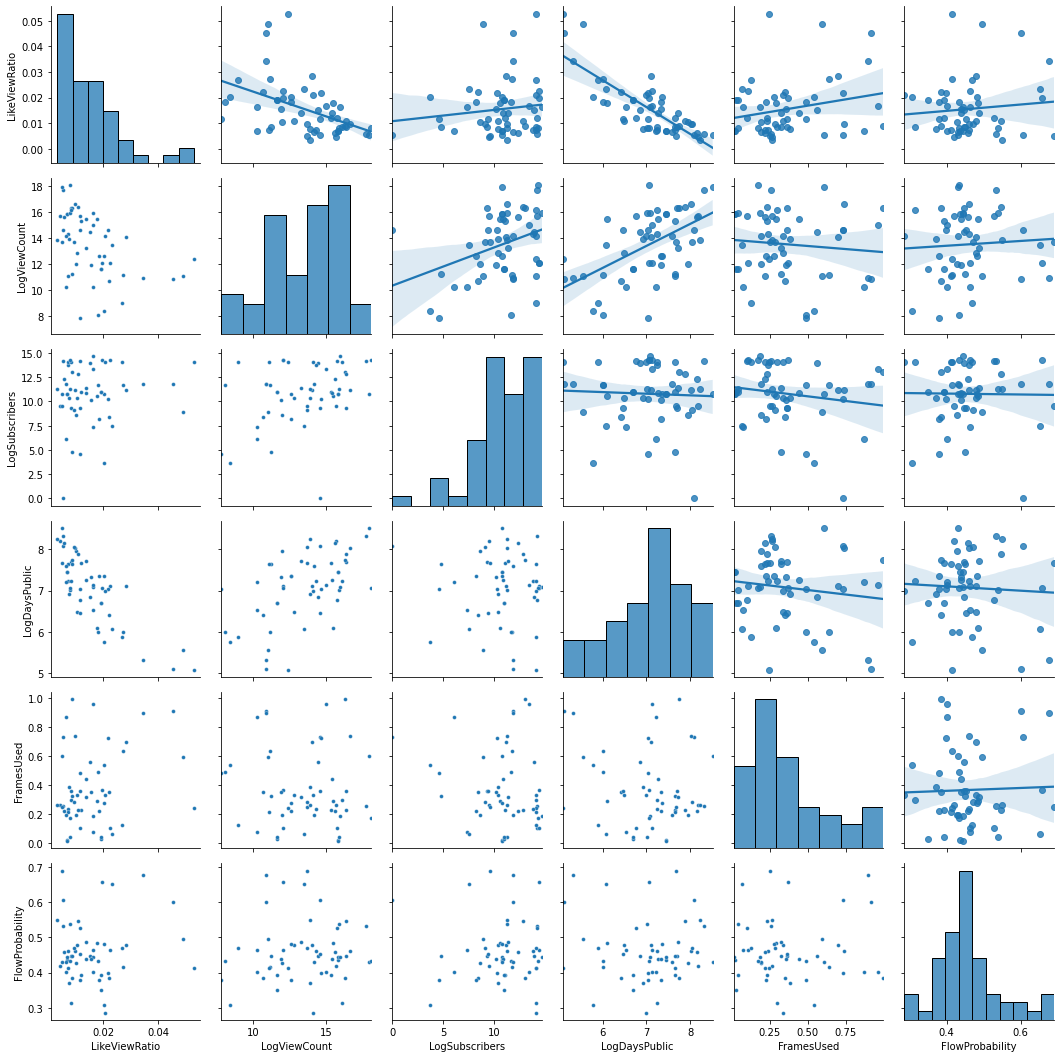

In [7]:
columns_to_show = ['LikeViewRatio',
                   'LogViewCount',
                   'LogSubscribers',
                   'LogDaysPublic',
                   'FramesUsed',
                   'FlowProbability']

g = sns.PairGrid(final_data[columns_to_show], diag_sharey=False)
g.map_upper(sns.regplot)
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot, s=15);

In [12]:
X = final_data[['FlowProbability', 'LogViewCount', 'LogDaysPublic','LogSubscribers','FramesUsed']]
y = final_data['LikeViewRatio']


model = sm.OLS(y,X)
model = model.fit(cov_type='hc3')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          LikeViewRatio   R-squared (uncentered):                   0.789
Model:                            OLS   Adj. R-squared (uncentered):              0.768
Method:                 Least Squares   F-statistic:                              31.98
Date:                Thu, 05 Nov 2020   Prob (F-statistic):                    1.33e-14
Time:                        09:49:32   Log-Likelihood:                          186.69
No. Observations:                  56   AIC:                                     -363.4
Df Residuals:                      51   BIC:                                     -353.2
Df Model:                           5                                                  
Covariance Type:                  hc3                                                  
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
FlowProbability     0.0463      0.015      3.119      0.002       0.017       0.075
LogViewCount       -0.0010      0.001     -2.076      0.038      -0.002   -5.85e-05
LogDaysPublic      -0.0020      0.001     -1.438      0.151      -0.005       0.001
LogSubscribers      0.0016      0.000      3.655      0.000       0.001       0.002
FramesUsed          0.0136      0.005      2.810      0.005       0.004       0.023
==============================================================================
Omnibus:                       16.383   Durbin-Watson:                   2.144
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.894
Skew:                           1.070   Prob(JB):                     1.76e-05
Kurtosis:                       5.192   Cond. No.                         194.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC3)
"""

<Figure size 1080x1440 with 0 Axes>

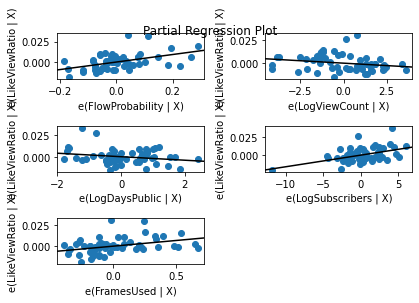

In [9]:
fig = plt.figure(figsize=(15,20), constrained_layout=True)
fig = sm.graphics.plot_partregress_grid(model)

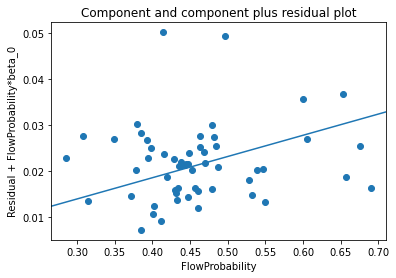

In [10]:
fig = sm.graphics.plot_ccpr(model, 'FlowProbability')

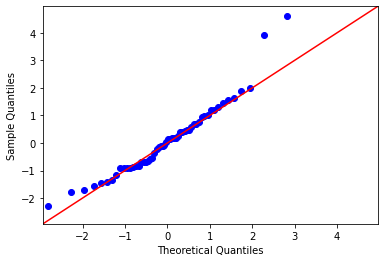

In [11]:
fig = sm.qqplot(model.resid, stats.t, fit=True, line="45")